<a href="https://colab.research.google.com/github/moitrishm/phenotypicswitching/blob/main/Kussell_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#code to simulate phenotypic switching
import networkx as nx
import matplotlib.pyplot as plt    
from scipy.integrate import odeint
import numpy as np
from numpy import linalg as LA
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [ ]:
PHENOTYPES = 3 #np.linspace(3,8,6, dtype='int')
#ENVS=150
TIME_T = 10000
AVG = 100
h_opt = (1/((PHENOTYPES-1)*100))
ws = np.linspace(0, (h_opt), 20)
l_diff_sim = np.zeros(ws.size)
l_diff_solver = np.zeros(ws.size)
l_diff_t = np.zeros(ws.size)
l_diff_pseudo = np.zeros(ws.size)
l_diff_f = np.zeros(ws.size)
l_diff_k = np.zeros(ws.size)
average_durations = np.full(PHENOTYPES, AVG)
hs = np.linspace( (h_opt)/8, 3*h_opt, 40)

In [ ]:
h_opt

0.005

In [ ]:
ws = np.linspace(0, (h_opt), 20)

In [ ]:
hs = np.linspace( (h_opt), 4*h_opt, 40)
#hs[6] = 0.005
#hs[17] = 0.01
ws = np.linspace(0, h_opt, 40)

In [ ]:
proportions = np.linspace(0.3, 1, 16 )

In [ ]:
proportions

array([0.3       , 0.34666667, 0.39333333, 0.44      , 0.48666667,
       0.53333333, 0.58      , 0.62666667, 0.67333333, 0.72      ,
       0.76666667, 0.81333333, 0.86      , 0.90666667, 0.95333333,
       1.        ])

In [ ]:
def set_edge_weights(nodes, h, w):
    H = np.full((nodes,nodes),h)
    H[0][nodes-1] = h - w
    H[nodes-1][0] = h - w
    #H[0][2] = H[2][0] = 0
    #H[1][3] = H[3][1] = 0
    np.fill_diagonal(H,0)
    return H

def set_path_weights(nodes,h):
    H = nx.path_graph(nodes, create_using=nx.Graph)
    H1 = nx.to_numpy_array(H)
    return H1*h

def set_edge_weights_sparse(nodes, h, i):
    H=nx.gnm_random_graph(nodes, i*nodes*(nodes-1), directed=True)    #generate random graph of 10 nodes
    while(not(nx.is_strongly_connected(H))):
      H=nx.gnm_random_graph(nodes, i*nodes*(nodes-1), directed=True)
    H1=nx.to_numpy_array(H) #adjacency matrix
    H2= h* H1     
    H2=np.transpose(H2)
    return H2, H

def set_offset():
    s = 10
    return s

#def network_constructor(nodes, prob, H2):
#    H=nx.gnp_random_graph(nodes,prob, directed=False)    #generate random graph of 10 nodes
#    H1=nx.to_numpy_array(H) #adjacency matrix
#    H3=np.multiply(H1,(H2))      
#    Hf=np.transpose(H3)     #transpose to balance rates correctly
#    return H,Hf

def env_matrix_creator(nodes, k, s):
    G = np.zeros((nodes,nodes))   #growth rates of every phenotype
    #fitness = np.zeros(nodes)           #exclusive vector for fitness coefficients only
    #f=0
    temp = np.full(nodes, 0.1)
    temp[k] += s/10             #only one of the diagonal elements is 1+s
    np.fill_diagonal(G, temp)
    #f = np.sum(np.absolute(temp))
    #fitness = temp            
    return G

def rate_calc(H):
    rates = np.sum(H, axis=0)    #total out-switching rate vector for all phenotypes
    return rates    

def laplace(G,H,rates):                     #calculate co-efficient matrix for the three environments
    Gn = np.zeros((G.shape[0], G.shape[1]))
    np.fill_diagonal(Gn, G.diagonal() - rates )  #subtract out-switching rates from growth rates of every phenotype    
    return Gn+H

def create_final_path(nodes, h, w , j,s):
    H = set_path_weights(nodes,h)
    G = env_matrix_creator(nodes,j,s)
    rate = rate_calc(H)
    A = laplace(G,H,rate)
    return A

def generate_path_matrices(nodes, h, w, s):
    A = np.zeros((nodes, nodes, nodes))
    for i in range(nodes):
        A[i] = create_final_path(nodes, h, w, i,s)
    return A

def create_final_matrix(nodes,h,w,j,s):
    H = set_edge_weights(nodes,h,w)
    G = env_matrix_creator(nodes,j,s)
    rate = rate_calc(H)
    A = laplace(G,H,rate)
    return A

def generate_matrices(nodes, h, w, s):
    A = np.zeros((nodes, nodes, nodes))
    for i in range(nodes):
        A[i] = create_final_matrix(nodes, h, w, i,s)
    return A

def create_final_smatrix(nodes,h, j,i,s):
    H, Hd = set_edge_weights_sparse(nodes,h,i)
    G = env_matrix_creator(nodes,j,s)
    rate = rate_calc(H)
    A = laplace(G,H,rate)
    return A, Hd


def generate_sparse_matrices(nodes, h, i, s):
    A = np.zeros((nodes, nodes, nodes))
    for l in range(nodes):
        A[l], G = create_final_smatrix(nodes, h, l, i,s)
    return A, G


def generate_environment_sequence(nodes):
    envs = np.zeros(1000, dtype=int)
    envs[0] = np.random.randint(1,nodes+1)
    for i in range(1,envs.size):
        envs[i] = np.random.randint(1,nodes+1)
        while(envs[i] == envs[i-1]):
            envs[i] = np.random.randint(1,nodes+1)
    return envs

#def generate_durations(envs):
#    total_times = np.zeros(1)           #array of total time at every switch
#    indiv_times = np.zeros(1)           #array of individual durations
#    t_total_count = 0                   #count of total time 
#    times_indiv = np.zeros(1)           #arrays for appending 
#    times_total = np.zeros(1)
#    k=0                                #keep count of how many environments used
#    for i in range(envs.size):
#        if((TIME_T - t_total_count) < 0):        #break out if time exceeds total
#            break
#        if((TIME_T-t_total_count) < AVG):         #last entry of durations
#            time = TIME_T - t_total_count
#            times_indiv[0] = time
#            t_total_count += time
#            k+=1
#            times_total[0] = t_total_count
#            indiv_times = np.append(indiv_times, times_indiv)
#            total_times = np.append(total_times, times_total)
#            break
#        time = np.random.exponential(lambda_[(envs[i]-1)], 1)[0]
#        if(time<0.01):          #consistent with discretization of manual solver
#            time = 0.01
#        times_indiv[0] = time
#        t_total_count += time
#        k+=1
#        times_total[0] = t_total_count
#        indiv_times = np.append(indiv_times, times_indiv)
#        total_times = np.append(total_times, times_total)
 
#    real_envs = envs[:k]   #trim environment sequence 
#    total_times = np.delete(total_times,0)
#    indiv_times = np.delete(indiv_times,0)
#    return real_envs, indiv_times

def generate_durations1(envs):
    indiv_times = np.zeros(envs.size)
    for i in range(envs.size):
        indiv_times[i] = np.random.exponential(average_durations[(envs[i]-1)],1)[0]
    indiv_times = np.max([indiv_times, np.ones(indiv_times.shape)*0.01], axis=0)
    c_indiv = np.cumsum(indiv_times)
    k = np.argmax(c_indiv>TIME_T)
    c_indiv = c_indiv[:k+1]
    real_envs = envs[:k+1]
    ind_times = indiv_times[:k+1]
    return real_envs, ind_times, c_indiv

def calculate_p(envs):
    p0 = np.count_nonzero(envs==1)/envs.size
    p1 = np.count_nonzero(envs==2)/envs.size
    p2 = np.count_nonzero(envs==3)/envs.size
    return p0, p1, p2

def calculate_b(envs):
    b0 = np.count_nonzero(envs==1)
    b10 = 0
    b20 = 0
    b1 = np.count_nonzero(envs==2)
    b01 = 0
    b21 = 0
    b2 = np.count_nonzero(envs==3)
    b02 = 0
    b12 = 0
    for i in range(0,envs.size-1):
        if(envs[i]==1):
            if(envs[i+1]==2):
                b10 +=1
            elif(envs[i+1]==3):
                b20 +=1
        elif(envs[i]==2):
            if(envs[i+1]==1):
                b01 +=1
            elif(envs[i+1]==3):
                b21 +=1
        elif(envs[i]==3):
            if(envs[i+1]==1):
                b02 +=1
            elif(envs[i+1]==2):
               b12 +=1
    return (b10/b0),(b20/b0), (b01/b1), (b21/b1), (b02/b2), (b12/b2)
    

def manual_solver(nodes, initials, A, tshift, time):
    t = np.linspace(tshift, tshift+ time, int(100*(time)))
    sol = np.zeros((nodes, t.size), dtype=np.float128)
    sol[:,0] = initials
    for i in range(1,t.size):
        sol[:,i] = sol[:,i-1] + (A @ sol[:,i-1]) * (t[i]-t[i-1])
    return sol, t, sol[:,t.size-1]

def deriv(y, t, A):         #system of ODEs defined and then solved
    dNdt = A @ y
    return dNdt

def solver(nodes,initials, A, tshift,time):    #function to solve system at every environment
    t = np.linspace(tshift, tshift+ time, 100*(time))            #time including current + sample from exp
    sol = odeint(deriv, initials, t, args=(A,))
    return sol, t, sol[t.size-1]

def simulate(nodes, A, real_envs, indiv_times):        #using manual solver
    init = np.zeros(nodes, dtype=np.float128)        #vector of initial conditions
    sol_final = np.ones((nodes,1), dtype=np.float128)        #stub for appending solution vector at each step
    t_final = np.ones(1)              #stub for appending time array of every environment 
    t_start=0     #variable to keep track of the relative starting point of every environmental switch   
    tracker = np.ones(1, dtype='int')
    for i in range(nodes):          #initialise population
        init[i]= 5e-60
    for i in range(real_envs.size):             #iterate through random array to decide which environment will occur 
        solution, time_array, init = manual_solver(PHENOTYPES,init, A[(real_envs[i]-1)], t_start, indiv_times[i])       #solver outputs solution array, corresponding time array and initial values for next step
        t_start = time_array[time_array.size-1]               #new starting time for next environment
        sol_final = np.append(sol_final, solution, axis=1)      #final solution vector
        t_final = np.append(t_final,time_array)                  #final time vector 
        temp = np.full(time_array.size, real_envs[i])
        tracker = np.append(tracker,temp)
    t_final = t_final[1:]
    tracker = tracker[1:]
    sol_final = sol_final[:,1:]
    return sol_final, t_final , tracker



def simulate_solver(nodes, A, real_envs, indiv_times):
    init = np.zeros(nodes, dtype=np.float64)        #vector of initial conditions
    sol_final = np.ones((1,nodes), dtype=np.float64)        #stub for appending solution vector at each step
    t_final = np.ones(1)              #stub for appending time array of every environment 
    t_start=0     #variable to keep track of the relative starting point of every environmental switch              
    t_total = 0
    for i in range(nodes):          #initialise population
        init[i]= 0.00005
    for i in range(real_envs.size):             #iterate through random array to decide which environment will occur 
        solution, time_array, init = solver(PHENOTYPES,init, A[(real_envs[i]-1)], t_start, indiv_times[i])       #solver outputs solution array, corresponding time array and initial values for next step
        t_start = time_array[time_array.size-1]               #new starting time for next environment
        sol_final = np.append(sol_final, solution, axis=0)      #final solution vector
        t_final = np.append(t_final,time_array)                  #final time vector
    sol_final = np.transpose(sol_final)
    return sol_final, t_final 
    
def get_top_ev(A):
    e, v = LA.eig(A)
    k = np.argmax(e)
    vmax = v[:,k]/np.sum(v[:,k], axis = 0)
    return vmax, e[k]

def get_all_evs(A, nodes):
    v = np.zeros((nodes, nodes))
    l = np.zeros(nodes)
    for i in range(nodes):
        v[i], l[i] = get_top_ev(A[i])
    return v, l

def prop(s, j):        #calculates proportions of each phenotype from final sol vector, can be optimised further 
    pop=np.zeros(s.shape[0])
    d = np.sum(s, axis=0)
    d[0] = 1
    pop = s[j,:] / d  
    return pop

def lyap(A, tracker, t,sol_final):                      #calculate lyapunov exponent 
    s=np.sum(sol_final, axis=0)
    total = np.zeros(s.size)
    l=np.zeros(s.size)
    s[0] = 1
    t[0] = 1
    for i in range(s.size):
        l[i] = np.log(s[i])/t[i]
        k = int(tracker[i] - 1)
        f = np.diagonal(A[k])
        for j in range(sol_final.shape[0]):
            total[i] += f[j] *((sol_final[j][i])/s[i])
    return l, total

def fit(A, s, tracker, t_final):     #calculate fitness from fitness vectors, sol and environment tracker
    total = np.zeros(s.shape[1])
    d=np.sum(s, axis=0)
    d[0] = 1
    k=0
    for i in range(s.shape[1]):
        k = int(tracker[i] - 1)
        f = np.diagonal(A[k])
        for j in range(s.shape[0]):
            total[i] += f[j] *((s[j][i])/d[i])
    return total


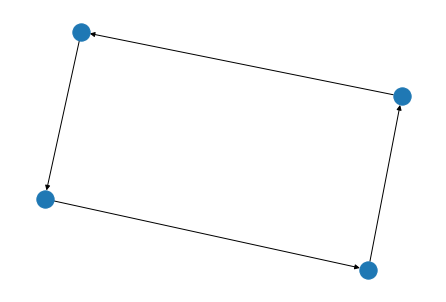

In [ ]:
A, G = generate_sparse_matrices(4, 0.005, 0.3, 10)
nx.draw(G)

In [ ]:
hs

array([0.005     , 0.00538462, 0.00576923, 0.00615385, 0.00653846,
       0.00692308, 0.00730769, 0.00769231, 0.00807692, 0.00846154,
       0.00884615, 0.00923077, 0.00961538, 0.01      , 0.01038462,
       0.01076923, 0.01115385, 0.01153846, 0.01192308, 0.01230769,
       0.01269231, 0.01307692, 0.01346154, 0.01384615, 0.01423077,
       0.01461538, 0.015     , 0.01538462, 0.01576923, 0.01615385,
       0.01653846, 0.01692308, 0.01730769, 0.01769231, 0.01807692,
       0.01846154, 0.01884615, 0.01923077, 0.01961538, 0.02      ])

In [ ]:
hvals = np.zeros((100, proportions.size))


In [ ]:
for m in range(100):
  s = set_offset()  
  envs=generate_environment_sequence(PHENOTYPES)
  real_envs, indiv_times,t = generate_durations1(envs)
  p0, p1, p2 = calculate_p(real_envs)
  b10, b20, b01, b21, b02, b12 = calculate_b(real_envs)
  l_t = np.zeros((proportions.size, hs.size))
  l_t1 = np.zeros((hs.size, proportions.size))
  for i in range(proportions.size):
      for j in range(hs.size):
          A, G=generate_sparse_matrices(PHENOTYPES, hs[j], proportions[i], s)
          if(nx.is_strongly_connected(G)==False):
            print('Error')
          vectors, values = get_all_evs(A, PHENOTYPES)
          v=1
          for k in range(vectors.shape[0]):
              for l in range(vectors.shape[0]):
                  v*=np.dot(vectors[k], vectors[l])
          l_t[i][j] = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(v)) / (PHENOTYPES*(PHENOTYPES-1)))/AVG
          maxes = np.argmax(l_t, axis=1)
          for n in range(maxes.size):
            hvals[m][n] = hs[maxes[n]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:251: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
hvals.shape

(100, 14)

In [ ]:
total = np.zeros(proportions.size)
h_opt0 = h_opt
for i in range(proportions.size):
  for j in range(100):
    total[i] += hvals[j][i]


In [ ]:
total1 = np.zeros(proportions.size)
h_opt1 = h_opt
for i in range(proportions.size):
  for j in range(100):
    total1[i] += hvals[j][i]

In [ ]:
total2 = np.zeros(proportions.size)
h_opt2 = h_opt
for i in range(proportions.size):
  for j in range(100):
    total2[i] += hvals[j][i]

In [ ]:
total3 = np.zeros(proportions.size)
h_opt3 = h_opt
for i in range(proportions.size):
  for j in range(100):
    total3[i] += hvals[j][i]

In [ ]:
total4 = np.zeros(proportions.size)
h_opt4 = h_opt
for i in range(proportions.size):
  for j in range(100):
    total4[i] += hvals[j][i]

In [ ]:
total5 = np.zeros(proportions.size)
h_opt5 = h_opt
for i in range(proportions.size):
  for j in range(100):
    total5[i] += hvals[j][i]

In [ ]:
total_m= np.insert(total, 0, total[0])
total = np.insert(total_m, 0, total_m[0])

In [ ]:
totals = np.load('totals.npz')

In [ ]:
total = totals['total']
total1 = totals['total1']
total2 = totals['total2']
total3 = totals['total3']
total4 = totals['total4']


In [ ]:
h_opt0 = 1/(2*100)
h_opt1 = 1/(300)
h_opt2 = 1/400
h_opt3  = 1/500
h_opt4  = 1/600

In [ ]:
hvals[0]/(100*h_opt3)

array([0.00570513, 0.00482051, 0.00364103, 0.00349359, 0.00305128,
       0.00275641, 0.00290385, 0.00334615, 0.00216667, 0.00260897,
       0.00201923, 0.0023141 , 0.00201923, 0.0023141 , 0.00187179,
       0.00201923])

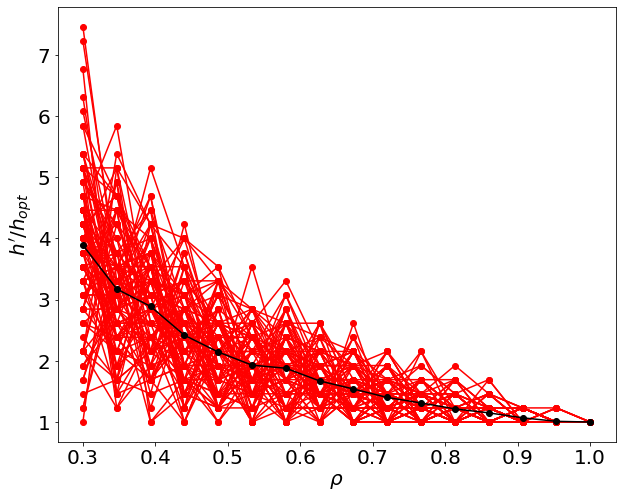

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.rc('font', size=20)
plt.rc('axes', titlesize=30)
plt.ylabel('$ h \' / h_{opt}$')
plt.xlabel( r'$ \rho $')
for i in range(100):
  plt.plot(proportions, hvals[i]/(h_opt4), linestyle = '-', marker = 'o', color='red')#, label = '3 nodes')
plt.plot(proportions, total4/(100*h_opt4), linestyle = '-', marker = 'o', color='black') #, label= '4 nodes')

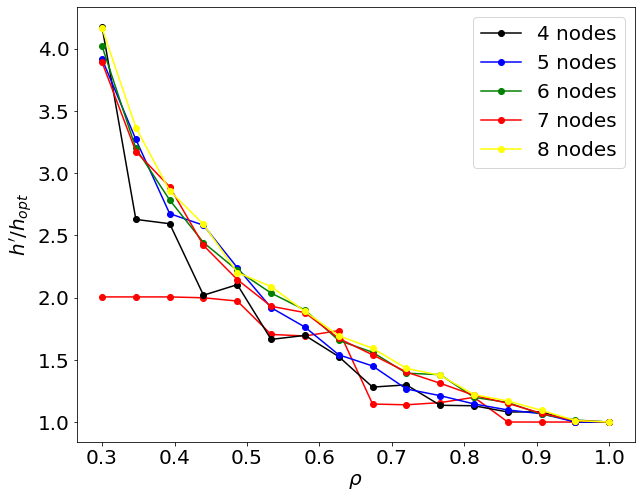

In [ ]:
#maxes = np.argmax(l_t, axis=1)
#hvals = np.zeros(maxes.size)
#for i in range(maxes.size):
#  hvals [i] = hs[maxes[i]]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.rc('font', size=20)
plt.rc('axes', titlesize=30)
plt.ylabel('$ h \' / h_{opt}$')
plt.xlabel( r'$ \rho $')
#plt.plot(t_final, lpt[0], linestyle = '-', color ='g', label  = r"Fitness")
#plt.plot(t_final, lpt[1], linestyle = '--', color ='g', label  = r"Fitness")
#plt.plot(t_final, lpt[2], linestyle = '--', color ='black', label  = r"Fitness")
#for i in range(100):
#  plt.plot(proportions, hvals[i]/h_opt, linestyle ='--', marker = 'o', color ='black') #, label  = r"Fitness function")
plt.plot(proportions, total/(100*h_opt0), linestyle = '-', marker = 'o', color='red')#, label = '3 nodes')
plt.plot(proportions, total1/(100*h_opt1), linestyle = '-', marker = 'o', color='black', label= '4 nodes')
plt.plot(proportions, total2/(100*h_opt2), linestyle = '-', marker = 'o', color='blue', label= '5 nodes')
plt.plot(proportions, total3/(100*h_opt3), linestyle = '-', marker = 'o', color='green', label= '6 nodes')
plt.plot(proportions, total4/(100*h_opt4), linestyle = '-', marker = 'o', color='red', label= '7 nodes')
#plt.scatter(densities, modified_h, marker='o', label = 'Type 1 (Paths)')
#plt.scatter(densities1, modified_h1, marker='s', label = 'Type 2')
#plt.text(densities+.03, modified_h+.03, labels, fontsize=9)
#labels = ['3 nodes', '4 nodes', '5 nodes', '6 nodes', '7 nodes']
#labels1 = ['3 nodes', '4 nodes']
#for i, txt in enumerate(labels):
#    plt.annotate(txt, (densities[i]+0.02, modified_h[i]))
#for i, txt in enumerate(labels1):
  
#   plt.annotate(txt, (densities1[i] +0.02, modified_h1[i]))
plt.plot(proportions, total5/(100*h_opt5), linestyle = '-', marker = 'o', color='yellow', label= '8 nodes')
plt.legend(loc="upper right")

In [ ]:
np.savez('totals.npz', total=total, total1=total1, total2=total2, total3 = total3, total4=total4)

In [ ]:
modified_h 

[1.97435897, 3.25641026, 5.0, 6.94871795, 9.30769231]

In [ ]:
A, G=generate_sparse_matrices(PHENOTYPES, (h_opt)/8, 0.3, s)
if(nx.is_strongly_connected(G)==False):
  print('Error')
vectors, values = get_all_evs(A, PHENOTYPES)
v=1
for k in range(vectors.shape[0]):
  for l in range(vectors.shape[0]):
    v*=np.dot(vectors[k], vectors[l])
l_t = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(v)) / (PHENOTYPES*(PHENOTYPES-1)))/AVG

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:251: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [ ]:
v=1
for k in range(vectors.shape[0]):
  for l in range(vectors.shape[0]):
    v*=np.dot(vectors[k], vectors[l])
    print(v)

In [ ]:
l_t

1.027817734004145

In [ ]:
s = set_offset()
envs=generate_environment_sequence(PHENOTYPES)
real_envs, indiv_times,t = generate_durations1(envs)
p0, p1, p2 = calculate_p(real_envs)
b10, b20, b01, b21, b02, b12 = calculate_b(real_envs)
l_t = np.zeros((hs.size, ws.size))
l_t1 = np.zeros((hs.size, ws.size))
for i in range(ws.size):
    for j in range(hs.size):
        A=generate_matrices(PHENOTYPES, hs[j], ws[i], s)
        vectors, values = get_all_evs(A, PHENOTYPES)
        v=1
        for k in range(vectors.shape[0]):
            for l in range(vectors.shape[0]):
                v*=np.dot(vectors[k], vectors[l])
        l_t[i][j] = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(v)) / (PHENOTYPES*(PHENOTYPES-1)))/AVG
        #l_t[i][j] = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(np.dot(vectors[0],vectors[1])) + np.log(np.dot(vectors[1], vectors[2])) + np.log(np.dot(vectors[2],vectors[0]))) / 3)/AVG
#sol_final, t_final, tracker = simulate(PHENOTYPES, A, real_envs, indiv_times)
#lyap_s, lyap_f = lyap(A, tracker, t_final, sol_final)
#B = generate_matrices(PHENOTYPES, h_opt, h_opt, s)
                     
#sol_final1, t_final1, tracker1 = simulate(PHENOTYPES, B, real_envs, indiv_times)
#lyap_s1, lyap_f1 = lyap(B, tracker1, t_final1, sol_final1)
#lpt = np.zeros((3, t_final.size ))
#for i in range(3):
#    B=generate_matrices(PHENOTYPES, h_opt, w[i], s)
#    sol_final, t_final, tracker = simulate(PHENOTYPES, A, real_envs, indiv_times)
#sol_final_s, t_final_s = simulate_solver(PHENOTYPES, A, real_envs, indiv_times)
#    lpt[i], lyap_f = lyap(A, tracker, t_final, sol_final)
#pop1 = prop(sol_final,0)
#pop2 = prop(sol_final,1)
#pop3 = prop(sol_final,2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:251: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
l_t1



1.0308501616090995

In [ ]:
PHENOTYPES = np.linspace(3,8,6, dtype='int')



In [ ]:
s = set_offset()
l_t1 = np.zeros((PHENOTYPES.size,hs.size))
for i in range(PHENOTYPES.size):
    for j in range(hs.size):
        A = generate_matrices(PHENOTYPES[i], hs[j], h_opt, s)
        vectors, values = get_all_evs(A, PHENOTYPES[i])
        v=1
        
        for k in range(vectors.shape[0]):
            for l in range(vectors.shape[0]):
                v*=np.dot(vectors[k], vectors[l])
        l_t1[i][j] = ((AVG/PHENOTYPES[i])*np.sum(values, axis=0) + (np.log(v)) / (PHENOTYPES[i]*(PHENOTYPES[i] - 1)))/AVG

<ipython-input-4-10303f260a91>:227: ComplexWarning: Casting complex values to real discards the imaginary part
  v[i], l[i] = get_top_ev(A[i])


In [ ]:
PHENOTYPES = 7
h_opt = 1/ ((PHENOTYPES-1)*100)
hs = np.linspace(h_opt/2, 3*h_opt, 40)
s = set_offset()
l_t1 = np.zeros(hs.size)
for j in range(hs.size):
  A = generate_matrices(PHENOTYPES, hs[j], hs[j], s)
  vectors, values = get_all_evs(A, PHENOTYPES)
  v=1
  for k in range(vectors.shape[0]):
    for l in range(vectors.shape[0]):
      v*=np.dot(vectors[k], vectors[l])
  l_t1[j] = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(v)) / (PHENOTYPES*(PHENOTYPES - 1)))/AVG
maxes = np.argmax(l_t1)
hval = hs[maxes]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:251: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
l_t1

array([      -inf,       -inf,       -inf,       -inf, 0.92326459,
       0.92629114, 0.92905296, 0.93149393, 0.93371234, 0.9357206 ,
       0.93755771, 0.93925318, 0.94081932, 0.94227499, 0.9436336 ,
       0.94490528, 0.9461    , 0.94722415, 0.94828512, 0.94928053,
       0.95023163, 0.95113446, 0.95199286, 0.95281084, 0.95359055,
       0.95433538, 0.95505668, 0.95573858, 0.95639192, 0.95701851,
       0.95761994, 0.9581977 , 0.9587532 , 0.95928758, 0.95980207,
       0.96029766, 0.96077536, 0.96123603, 0.96168055, 0.96210963])

In [ ]:
modified_h = np.zeros(5)


In [ ]:
modified_h[4] = hval/h_opt

In [ ]:
modified_h

array([1.97435897, 3.25641026, 5.        , 6.94871795, 9.30769231])

In [ ]:
hval/h_opt

1.076923076923077

In [ ]:
modified_h1

[1.94230769, 1.3974359, 1.20512821, 1.14102564, 1.07692308]

In [ ]:
modified_h1[4] = hval/h_opt

In [ ]:
densities = np.zeros(5)
densities1 = np.zeros(5)

In [ ]:
for i in range(5):
  n = i + 3
  densities[i] = 2*(n-1)/ (n*(n-1))
  densities1[i] = ((n*(n-1))-2)/(n*(n-1))

In [ ]:
densities1

array([0.66666667, 0.83333333, 0.9       , 0.93333333, 0.95238095])

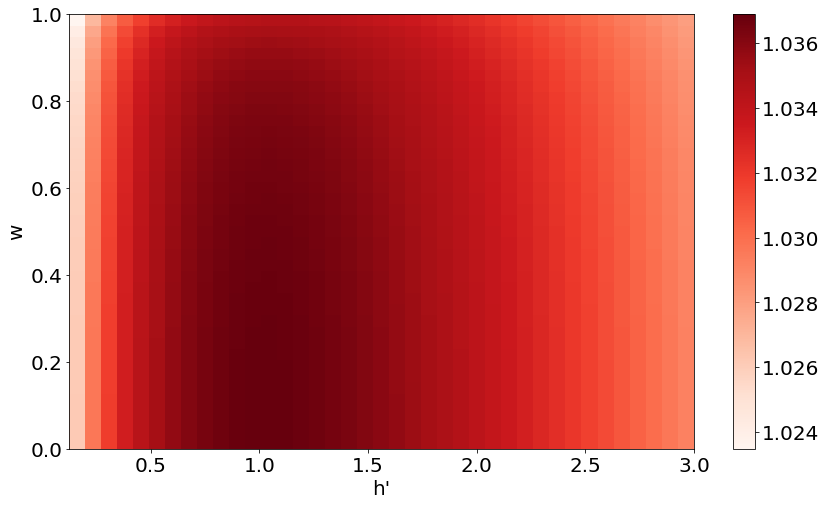

In [ ]:
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)
plt.rc('font', size=20)
plt.rc('axes', titlesize=30)
plt.xlabel('h\'')
plt.ylabel('w') #r"$\Lambda$")
plt.pcolormesh( hs/h_opt, ws/h_opt, l_t, cmap = 'Reds')
#for i in range(ws.size):
#    plt.scatter(hs[maxes[i]],ws[i])
#plt.xlim([0.0025, 0.02])
#plt.ylim([0,0.00505])
plt.colorbar()

In [ ]:
maxes = np.zeros(ws.size, dtype='int')
for i in range(ws.size):
    maxes[i]=np.argmax(l_t[i])


In [ ]:
A = generate_matrices(PHENOTYPES, h_opt, 0,s)
vectors, values = get_all_evs(A, PHENOTYPES)
l_theory = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(np.dot(vectors[0],vectors[1])) + np.log(np.dot(vectors[1], vectors[2])) + np.log(np.dot(vectors[2],vectors[0]))+np.log(np.dot(vectors[3], vectors[0]))+np.log(np.dot(vectors[3], vectors[1]))+ np.log(np.dot(vectors[3], vectors[2]))) / 4)/AVG



<ipython-input-1335-840870ba835c>:209: ComplexWarning: Casting complex values to real discards the imaginary part
  v[i], l[i] = get_top_ev(A[i])


In [ ]:
v

1.3503427936321495e-14

In [ ]:
np.dot(vectors[0],vectors[1])* np.dot(vectors[1], vectors[2]) * np.dot(vectors[2],vectors[0]) * np.dot(vectors[3], vectors[0]) * np.dot(vectors[3], vectors[1]) * np.dot(vectors[3], vectors[1])

1.3503427936322385e-14

In [ ]:
s = set_offset()
envs=generate_environment_sequence(PHENOTYPES)
real_envs, indiv_times,t = generate_durations1(envs)
p0, p1, p2 = calculate_p(real_envs)
b10, b20, b01, b21, b02, b12 = calculate_b(real_envs)
lpt = np.zeros(ws.size)
A=generate_matrices(PHENOTYPES, h_opt, 0, s)
sol_final, t_final, tracker = simulate(PHENOTYPES, A, real_envs, indiv_times)
#sol_final_s, t_final_s = simulate_solver(PHENOTYPES, A, real_envs, indiv_times)
l1, lyap_f = lyap(A, tracker, t_final, sol_final)
#l1_solver = lyap(t_final_s, sol_final_s)
l_sim = l1[l1.size-1]
#l_sim_solver = l1_solver[l1_solver.size-1]
vectors, values = get_all_evs(A, PHENOTYPES)
l_t = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(np.dot(vectors[0],vectors[1])) + np.log(np.dot(vectors[1], vectors[2])) + np.log(np.dot(vectors[2],vectors[0]))) / 3)/AVG
#l_t = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(np.dot(vectors[0],vectors[1])))/2)/AVG
l_pseudot = ((t/indiv_times.size)*(p0 * values[0] + p1*values[1] + p2*values[2]) + (p0 * b10 + p1*b01)*np.log(np.dot(vectors[0],vectors[1])) + (p1*b21 + p2*b12)*np.log(np.dot(vectors[1], vectors[2])) + (p0*b20 + p2*b02)*np.log(np.dot(vectors[2],vectors[0])))/(t/indiv_times.size)
#l_pseudot = ((t/indiv_times.size)*(p0 * values[0] + p1*values[1]) + (p0 * b10 + p1*b01)*np.log(np.dot(vectors[0],vectors[1])))/(t/indiv_times.size)
#lyap_f = fit(A, sol_final, tracker, t_final)
lk = ((AVG/PHENOTYPES)*(A[0][0][0] + A[1][1][1]+A[2][2][2]) - (np.log(1 + (s/(20*h_opt)))))/AVG
lf = np.average(lyap_f)
lps = np.zeros((ws.size, t_final.size))
lpf = np.zeros((ws.size, t_final.size))
for i in range(ws.size):
    B = generate_matrices(PHENOTYPES, h_opt, ws[i], s)
    sol_final_p, t_final_p, tracker = simulate(PHENOTYPES, B, real_envs, indiv_times)
    #sol_final_ps, t_final_ps = simulate_solver(PHENOTYPES, B, real_envs, indiv_times)
    lps[i], lpf[i] = lyap(B, tracker, t_final_p, sol_final_p)
    #lpf[i] = fit(B, sol_final_p, tracker, t_final_p)
    #lps = lyap(t_final_ps, sol_final_ps)
    vectors, values = get_all_evs(B, PHENOTYPES)
    lp_t = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(np.dot(vectors[0],vectors[1])) + np.log(np.dot(vectors[1], vectors[2])) + np.log(np.dot(vectors[2],vectors[0]))) / 3)/AVG
    #lp_t = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(np.dot(vectors[0],vectors[1])))/2)/AVG
    lpt[i] = lp_t
    lkp = ((AVG/PHENOTYPES)*(B[0][0][0] + B[1][1][1]+B[2][2][2]) - (1/6)*(4*np.log(1 + (s/(20*h_opt)))+2*np.log(1+(s/(20*(h_opt-ws[i]))))))/AVG
    lp_pseudot = ((t/indiv_times.size)*(p0 * values[0] + p1*values[1] + p2*values[2]) + (p0 * b10 + p1*b01)*np.log(np.dot(vectors[0],vectors[1])) + (p1*b21 + p2*b12)*np.log(np.dot(vectors[1], vectors[2])) + (p0*b20 + p2*b02)*np.log(np.dot(vectors[2],vectors[0])))/(t/indiv_times.size)
    #lp_pseudot = ((t/indiv_times.size)*(p0 * values[0] + p1*values[1]) + (p0 * b10 + p1*b01)*np.log(np.dot(vectors[0],vectors[1])))/(t/indiv_times.size)
    l_diff_sim[i] = l_sim - lps[i][t_final.size-1]
    l_diff_pseudo[i] = l_pseudot - lp_pseudot
    l_diff_t[i] = l_t - lpt[i]
    l_diff_f[i] = lf - np.average(lpf[i])
    l_diff_k[i] = lk - lkp

<ipython-input-769-1708062f513c>:35: RuntimeWarning: divide by zero encountered in double_scalars
  lkp = ((AVG/PHENOTYPES)*(B[0][0][0] + B[1][1][1]+B[2][2][2]) - (1/6)*(4*np.log(1 + (s/(20*h_opt)))+2*np.log(1+(s/(20*(h_opt-ws[i]))))))/AVG


In [ ]:
h_opt = 0.005 
hs_new = np.linspace( h_opt/8, 4*h_opt, 20)
le4 = np.zeros(20)

In [ ]:
for i in range(20):
  s = set_offset()
  envs=generate_environment_sequence(PHENOTYPES)
  real_envs, indiv_times,t = generate_durations1(envs)
  p0, p1, p2 = calculate_p(real_envs)
  b10, b20, b01, b21, b02, b12 = calculate_b(real_envs)
  A=generate_matrices(PHENOTYPES, hs_new[i], hs_new[i], s)
  sol_final, t_final, tracker = simulate(PHENOTYPES, A, real_envs, indiv_times)
  #sol_final_s, t_final_s = simulate_solver(PHENOTYPES, A, real_envs, indiv_times)
  l1, lyap_f = lyap(A, tracker, t_final, sol_final)
  le4[i] = l1[l1.size-1] 

In [ ]:
lm = np.linspace(0.92, le[np.argmax(le)],100)
hm = np.full(100, hs_new[np.argmax(le)]/0.005)
lm1 = np.linspace(0.92, le1[np.argmax(le1)],100)
hm1 = np.full(100, hs_new[np.argmax(le1)]/0.005)
lm2 = np.linspace(0.92, le2[np.argmax(le2)],100)
hm2 = np.full(100, hs_new[np.argmax(le2)]/0.005)
lm3 = np.linspace(0.92, le3[np.argmax(le3)],100)
hm3 = np.full(100, hs_new[np.argmax(le3)]/0.005)
lm4 = np.linspace(0.92, le4[np.argmax(le4)],100)
hm4 = np.full(100, hs_new[np.argmax(le4)]/0.005)

(0.92, 1.04)

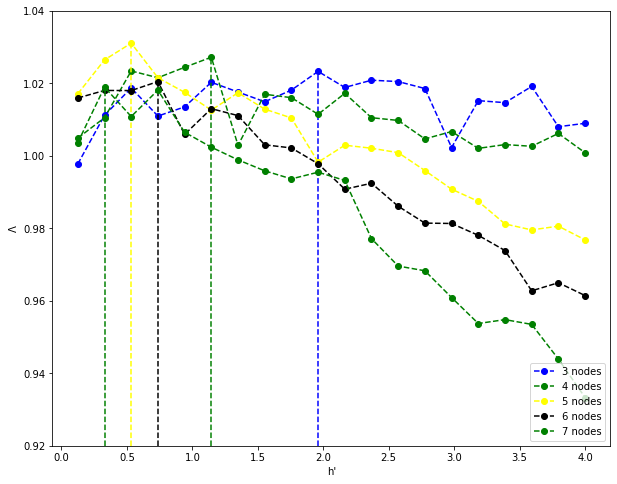

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.rc('font', size=10)
plt.rc('axes', titlesize=30)
plt.ylabel('$\Lambda$')
plt.xlabel('h\'')
#plt.plot(t_final, lpt[0], linestyle = '-', color ='g', label  = r"Fitness")
#plt.plot(t_final, lpt[1], linestyle = '--', color ='g', label  = r"Fitness")
#plt.plot(t_final, lpt[2], linestyle = '--', color ='black', label  = r"Fitness")
plt.plot(hs_new/0.005, le, linestyle = '--', marker='o', color ='blue', label  = r"3 nodes")
plt.plot(hm, lm, linestyle='--', color='blue')
plt.plot(hs_new/0.005, le1, linestyle = '--', marker='o', color ='green', label  = r"4 nodes")
plt.plot(hm1, lm1, linestyle='--', color='green')
plt.plot(hs_new/0.005, le2, linestyle = '--', marker='o', color ='yellow', label  = r"5 nodes")
plt.plot(hm2, lm2, linestyle='--', color ='yellow')
plt.plot(hs_new/0.005, le3, linestyle = '--', marker='o', color ='black', label  = r"6 nodes")
plt.plot(hm3, lm3, linestyle='--', color='black')
plt.plot(hs_new/0.005, le4, linestyle = '--', marker='o', color ='green', label  = r"7 nodes")
plt.plot(hm4, lm4, linestyle='--', color = 'green')


#plt.plot(t_final, lf, linestyle = '-', color ='black', label  = r"Simulations")
#plt.plot(t_final, lpt[2], linestyle = '-', color ='g', label  = r"Fitness")
plt.legend(loc="lower right")
#plt.xlim([5000,10000])
plt.ylim([0.92,1.04])


In [ ]:
ws = np.linspace(0, (h_opt), 20)
wd = np.linspace(ws[ws.size-2], ws[ws.size-1], 20)
ws = np.append(ws[:ws.size-2],wd[1:])
l_diff_t_extended = np.zeros(ws.size)
l_diff_k_extended = np.zeros(ws.size)
for i in range(ws.size):
    C = generate_matrices(PHENOTYPES, h_opt, ws[i], s)
    vectors, values = get_all_evs(C, PHENOTYPES)
    lp_t = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(np.dot(vectors[0],vectors[1])) + np.log(np.dot(vectors[1], vectors[2])) + np.log(np.dot(vectors[2],vectors[0]))) / 3)/AVG
    lkp = ((AVG/PHENOTYPES)*(C[0][0][0] + C[1][1][1]+C[2][2][2]) - (1/6)*(4*np.log(1 + (s/(20*h_opt)))+2*np.log(1+(s/(20*(h_opt-ws[i]))))))/AVG
    l_diff_t_extended[i] = l_t - lp_t
    l_diff_k_extended[i] = l_t - lkp


    

<ipython-input-877-7bc017ab91f3>:10: RuntimeWarning: divide by zero encountered in double_scalars
  lkp = ((AVG/PHENOTYPES)*(C[0][0][0] + C[1][1][1]+C[2][2][2]) - (1/6)*(4*np.log(1 + (s/(20*h_opt)))+2*np.log(1+(s/(20*(h_opt-ws[i]))))))/AVG


In [ ]:
ws = np.linspace(0, (h_opt), 20)
wd = np.linspace(ws[ws.size-2], ws[ws.size-1], 10)
ws = np.append(ws[:ws.size-1],wd[1:])
l_diff_t_e = np.zeros(ws.size)
l_diff_k_e = np.zeros(ws.size)
for i in range(ws.size):
    C = generate_matrices(PHENOTYPES, h_opt, ws[i], s)
    vectors, values = get_all_evs(C, PHENOTYPES)
    lp_t = ((AVG/PHENOTYPES)*np.sum(values, axis=0) + (np.log(np.dot(vectors[0],vectors[1])) + np.log(np.dot(vectors[1], vectors[2])) + np.log(np.dot(vectors[2],vectors[0]))) / 3)/AVG
    lkp = ((AVG/PHENOTYPES)*(C[0][0][0] + C[1][1][1]+C[2][2][2]) - (1/6)*(4*np.log(1 + (s/(20*h_opt)))+2*np.log(1+(s/(20*(h_opt-ws[i]))))))/AVG
    l_diff_t_e[i] = l_t - lp_t
    l_diff_k_e[i] = l_t - lkp

<ipython-input-813-baba6be8533c>:10: RuntimeWarning: divide by zero encountered in double_scalars
  lkp = ((AVG/PHENOTYPES)*(C[0][0][0] + C[1][1][1]+C[2][2][2]) - (1/6)*(4*np.log(1 + (s/(20*h_opt)))+2*np.log(1+(s/(20*(h_opt-ws[i]))))))/AVG


In [ ]:
np.savez('final_output', sims=l_diff_sim, theory = l_diff_t_e, formula = l_diff_k_e, pseudo = l_diff_pseudo, envs = real_envs)

In [ ]:
l_t1[4][[np.argmax(l_t1[4])]][0]

0.9741402047365568

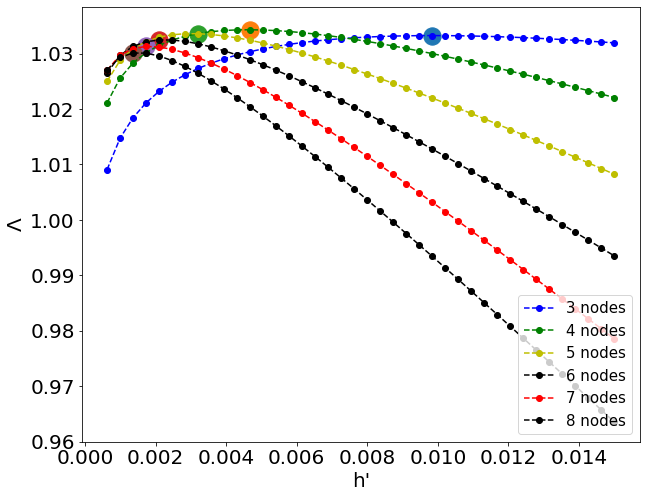

In [ ]:
#final_fit1, n1 = fit(fitness, sol_final, tracker)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.rc('font', size=20)
plt.rc('axes', titlesize=30)


#plt.plot(w_short, l_diff_sim, linestyle = '--', marker='o', color ='g', label  = r"Simulation")
#plt.plot(w_short, l_diff_pseudo, linestyle = '--', marker = 'o', color ='red', label  = r"Approximation II w.s.p")
#plt.plot(ws, l_diff_t_extended, linestyle = '-', marker='o', color ='b', label  = r"Approximation II")
#plt.plot(w_short, l_diff_f, linestyle = '-', color ='g', label  = r"Fitness")
#plt.plot(ws, l_diff_k_extended, linestyle = '--', marker='o', color ='black', label  = r"Approximation I")
#plt.axvline(x=1, linestyle = '--')
#plt.plot(ws, l_diff_solver, linestyle = '-', color ='black', label  = r"ODE Solver")
#plt.plot(hs, l_t, linestyle = '--', marker='o', color ='g', label  = r"Approximation II")
plt.plot(hs, l_t1[0], linestyle = '--', marker='o', color ='b', label  = r"3 nodes")
plt.scatter(hs[np.argmax(l_t1[0])], l_t1[0][[np.argmax(l_t1[0])]][0], s=300)
plt.plot(hs, l_t1[1], linestyle = '--', marker='o', color ='g' , label  = r"4 nodes")
plt.scatter(hs[np.argmax(l_t1[1])], l_t1[1][[np.argmax(l_t1[1])]][0], s=300)
plt.plot(hs, l_t1[2], linestyle = '--', marker='o', color ='y', label  = r"5 nodes")
plt.scatter(hs[np.argmax(l_t1[2])], l_t1[2][[np.argmax(l_t1[2])]][0], s=300)
plt.plot(hs, l_t1[3], linestyle = '--', marker='o', color ='black', label  = r"6 nodes")
plt.scatter(hs[np.argmax(l_t1[3])], l_t1[3][[np.argmax(l_t1[3])]][0], s=300)
plt.plot(hs, l_t1[4], linestyle = '--', marker='o', color ='r', label  = r"7 nodes")
plt.scatter(hs[np.argmax(l_t1[4])], l_t1[4][[np.argmax(l_t1[4])]][0], s=300)
plt.plot(hs, l_t1[5], linestyle = '--', marker='o', color ='black', label  = r"8 nodes")
plt.scatter(hs[np.argmax(l_t1[5])], l_t1[5][[np.argmax(l_t1[5])]][0], s=300)

#plt.plot(hs, l_t[39], linestyle = '--', marker='o', color ='r') #, label  = r"Approximation II")
#plt.plot(t_final2[2:t_final.size], l2, linestyle = '--', color ='g', label  = r"Partially Connected: P")

#plt.plot(t_final[2:t_final.size], lyap_t[2:t_final.size], linestyle = '--', color ='b', label  = r"Fully Connected: T")
#plt.plot(t_final[2:t_final.size], l2, linestyle = '--', color ='g', label  = r"Partially Connected")

#plt.plot(t_final, n1, linestyle = '-', color ='b', label  = r"Fully Connected")
#plt.plot(t_final, n2, linestyle = '--', color ='g', label  = r"Partially Connected")

#plt.plot(tfinal, pop1, linestyle = '-', color ='black', label  = r"$1$", linewidth=0.7)
#plt.plot(tfinal, pop1+pop2, linestyle = '-', color ='black', label  = r"$2$", linewidth=0.7)
#plt.plot(tfinal, pop1+pop2+pop3, linestyle = '-', color ='black', label  = r"$3$", linewidth=0.7)


plt.xlabel('h\'')
plt.ylabel(r"$ \Lambda$")
#legend_elements = [Patch(facecolor='blue',alpha=.5, edgecolor='black',label='1'), 
                  # Patch(facecolor='yellow', alpha=.5, edgecolor='black',label='2'), 
                  # Patch(facecolor='red', alpha=.5, edgecolor='black',label='3') ]
#w_l = [0, 0.001, 0.002, 0.003, 0.004, 0.005]
#labels = [0, 'h/1', 'h/2', 'h/3', 'h/4', 'h/5']

labels = np.linspace(0.5, 5, 40)
##plt.xticks(hs, labels)

plt.legend(loc="lower right", prop = { 'size' : 15})

#plt.savefig('differences.pdf')  



#plt.xlim([0.9, 1.005])


#plt.ylim([0.006, 0.016])

In [ ]:
labels

chararray([b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h',
           b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h',
           b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h',
           b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h', b'h'],
          dtype='|S1')

In [ ]:
H=nx.path_graph(4, create_using=nx.Graph)
H1 = nx.to_numpy_array(H)
H1*hs[0]

array([[0.    , 0.0025, 0.    , 0.    ],
       [0.0025, 0.    , 0.0025, 0.    ],
       [0.    , 0.0025, 0.    , 0.0025],
       [0.    , 0.    , 0.0025, 0.    ]])

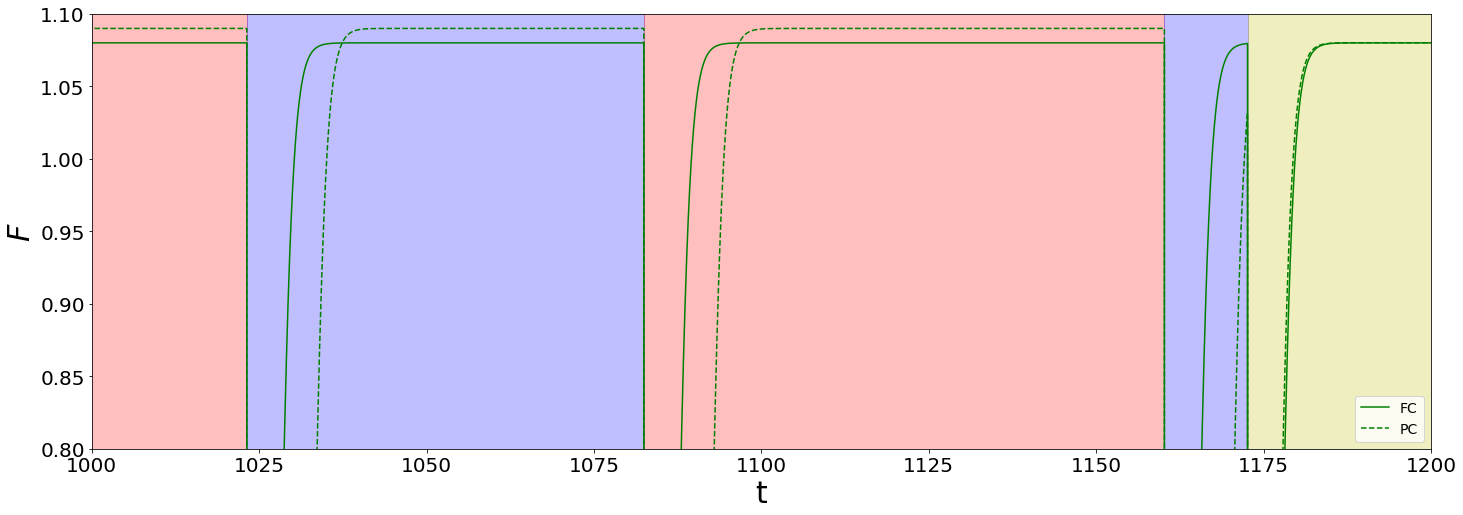

In [ ]:
fill = np.linspace(0, 1.2, 10)
f = plt.figure()
f.set_figwidth(24)
f.set_figheight(8)
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)


plt.plot(t_final, lyap_f, linestyle = '-', color ='green', label  = r"FC")
plt.plot(t_final, lyap_f1, linestyle = '--', color ='green', label  = r"PC")

#plt.plot(t_final, tracker_real/100, linestyle = '--', color ='black', label  = r"$Environment$")
#plt.plot(t_final, pop2, linestyle = '--', color ='y', label  = r"1")
#plt.plot(t_final, pop3, linestyle = '--', color ='r', label  = r"2")
#plt.plot(t_final, f_t, linestyle = '-', color ='black', label  = r"Theoretical Optimum")

#plt.plot(tfinal, pop1, linestyle = '-', color ='black', label  = r"$1$", linewidth=0.7)
#plt.plot(tfinal, pop1+pop2, linestyle = '-', color ='black', label  = r"$2$", linewidth=0.7)
#plt.plot(tfinal, pop1+pop2+pop3, linestyle = '-', color ='black', label  = r"$3$", linewidth=0.7)


plt.xlabel('t')
plt.ylabel(r"$F$")
#legend_elements = [Patch(facecolor='blue',alpha=.5, edgecolor='black',label='1'), 
                  # Patch(facecolor='yellow', alpha=.5, edgecolor='black',label='2'), 
                  # Patch(facecolor='red', alpha=.5, edgecolor='black',label='3') ]


#plt.legend(handles=legend_elements, loc='upper left')
plt.legend(loc="lower right")

plt.ylim([0.8, 1.1])
plt.xlim([1000, 1200])

plt.rc('xtick' , labelsize=20)
plt.rc('ytick' , labelsize=20)
plt.rc('axes', labelsize=30)
first=0
for i in range(real_envs.size):
    second = t[i]
    if(real_envs[i]==1):
        plt.fill_betweenx(fill, first, second, color='b', alpha=.25)
    elif(real_envs[i]==2):
        plt.fill_betweenx(fill, first, second, color='y', alpha=.25)
    elif(real_envs[i]==3):
        plt.fill_betweenx(fill, first, second, color='r', alpha=.25)
    first = t[i]
#plt.fill_between(tfinal, 0, pop1,color='b',alpha=.5)
#plt.fill_between(tfinal, pop1,pop1+pop2,color='y',alpha=.5)
#plt.fill_between(tfinal, pop1+pop2, pop1+pop2+pop3,color='r',alpha=.5)
plt.show()